## Import Important Libraries


In [1]:

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2024-04-26 05:41:54.404523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 05:41:54.404621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 05:41:54.532801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining the training and testing paths

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [7]:
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [8]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [9]:
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


## Defining the validation path

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=40, stratify=ts_df['Class'])

In [11]:
valid_df

,Class Path,Class
661,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
494,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
688,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
837,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1162,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
146,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
462,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
305,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
318,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


In [12]:
ts_df

,Class Path,Class
159,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1059,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1119,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1155,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1031,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
707,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
703,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
916,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


## Preparing the model


In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Defining the model to get the summary

In [14]:
img_shape=(299,299,3)
    
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())   

model.add(Flatten())

model.add(Dense(512,activation = "relu"))
model.add(Dropout(rate=0.30))
model.add(Dense(128,activation = "relu"))
model.add(Dropout(rate=0.20))
model.add(Dense(32,activation = "relu"))
model.add(Dropout(rate=0.10))
model.add(Dense(4, activation="softmax"))

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    89,719,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,882,468 (342.87 MB)

 Trainable params: 89,882,468 (342.87 MB)

 Non-trainable params: 0 (0.00 B)

## Running the model

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:06:13 22s/step - accuracy: 0.0938 - loss: 1.4061 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1714110207.221563     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714110207.246048     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5465 - loss: 1.0727 - precision: 0.6755 - recall: 0.3437

W0000 00:00:1714110275.338760     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714110277.116598     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 441ms/step - accuracy: 0.5472 - loss: 1.0712 - precision: 0.6760 - recall: 0.3448 - val_accuracy: 0.7939 - val_loss: 0.5556 - val_precision: 0.8110 - val_recall: 0.7664
Epoch 2/10


W0000 00:00:1714110285.915784     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.8396 - loss: 0.4568 - precision: 0.8619 - recall: 0.8067 - val_accuracy: 0.8382 - val_loss: 0.3977 - val_precision: 0.8517 - val_recall: 0.8153
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 203ms/step - accuracy: 0.8996 - loss: 0.2994 - precision: 0.9101 - recall: 0.8854 - val_accuracy: 0.9069 - val_loss: 0.2344 - val_precision: 0.9078 - val_recall: 0.9023
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.9227 - loss: 0.2082 - precision: 0.9289 - recall: 0.9157 - val_accuracy: 0.9267 - val_loss: 0.1952 - val_precision: 0.9281 - val_recall: 0.9267
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 203ms/step - accuracy: 0.9406 - loss: 0.1635 - precision: 0.9436 - recall: 0.9363 - val_accuracy: 0.9374 - val_loss: 0.1954 - val_precision: 0.9388 - val_recall: 0.9374
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.9651 - loss: 0.0939 - precision: 0.9674 - recall: 0.9629 - val_accuracy: 0.9542 - val_loss

In [16]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

## Calculating the respective accuracies

In [17]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.9997 - loss: 0.0056 - precision: 0.9997 - recall: 0.9997


W0000 00:00:1714110704.373580     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9663 - loss: 0.1140 - precision: 0.9663 - recall: 0.9663
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9619 - loss: 0.1727 - precision: 0.9619 - recall: 0.9619
Train Loss: 0.0067
Train Accuracy: 99.93%
--------------------
Validation Loss: 0.1349
Validation Accuracy: 96.49%
--------------------
Test Loss: 0.1575
Test Accuracy: 96.65%


## Predicting the model

In [18]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step 

W0000 00:00:1714110718.018642     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


## Classification report

In [19]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       150
           1       0.95      0.91      0.93       153
           2       0.97      1.00      0.99       203
           3       0.98      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.96      0.96       656
weighted avg       0.97      0.97      0.97       656



## Testing the model

In [20]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    print(predictions[0].argmax())
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0


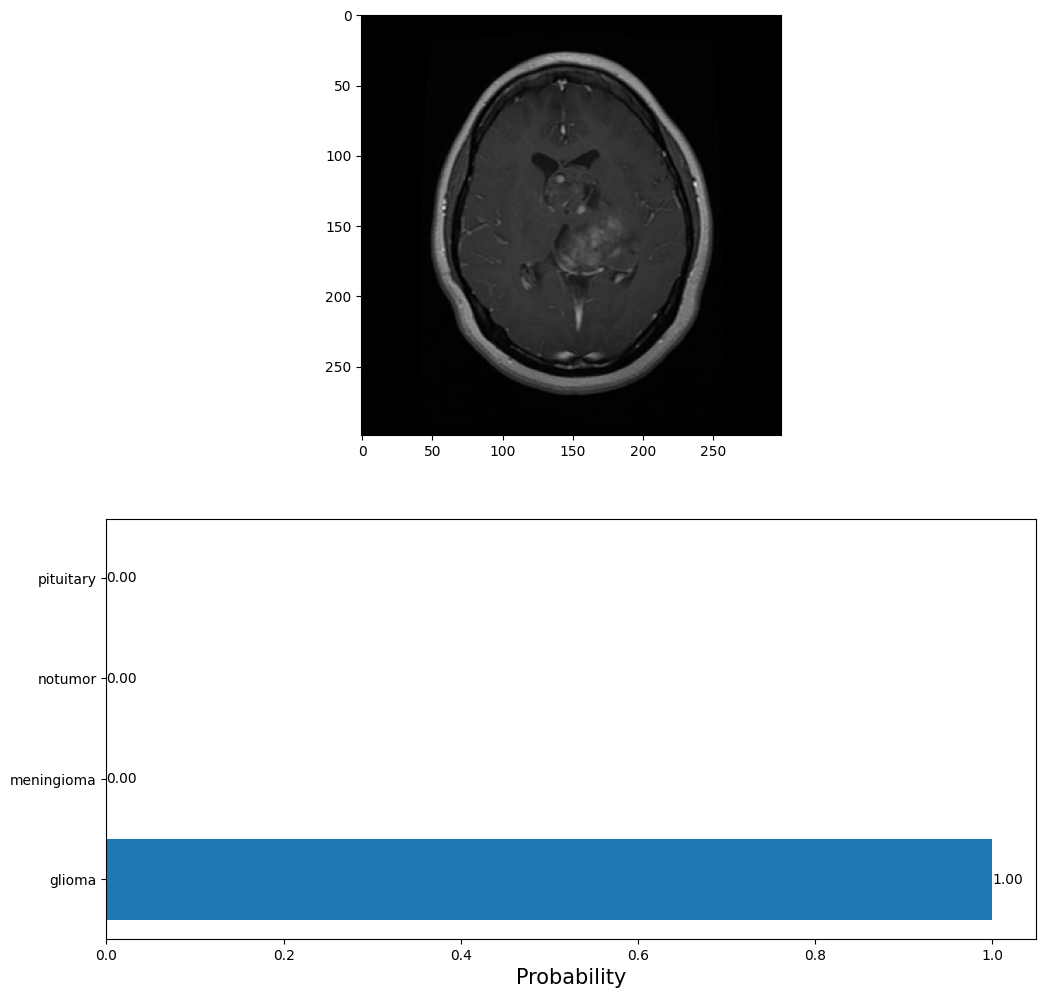

In [26]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0049.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2


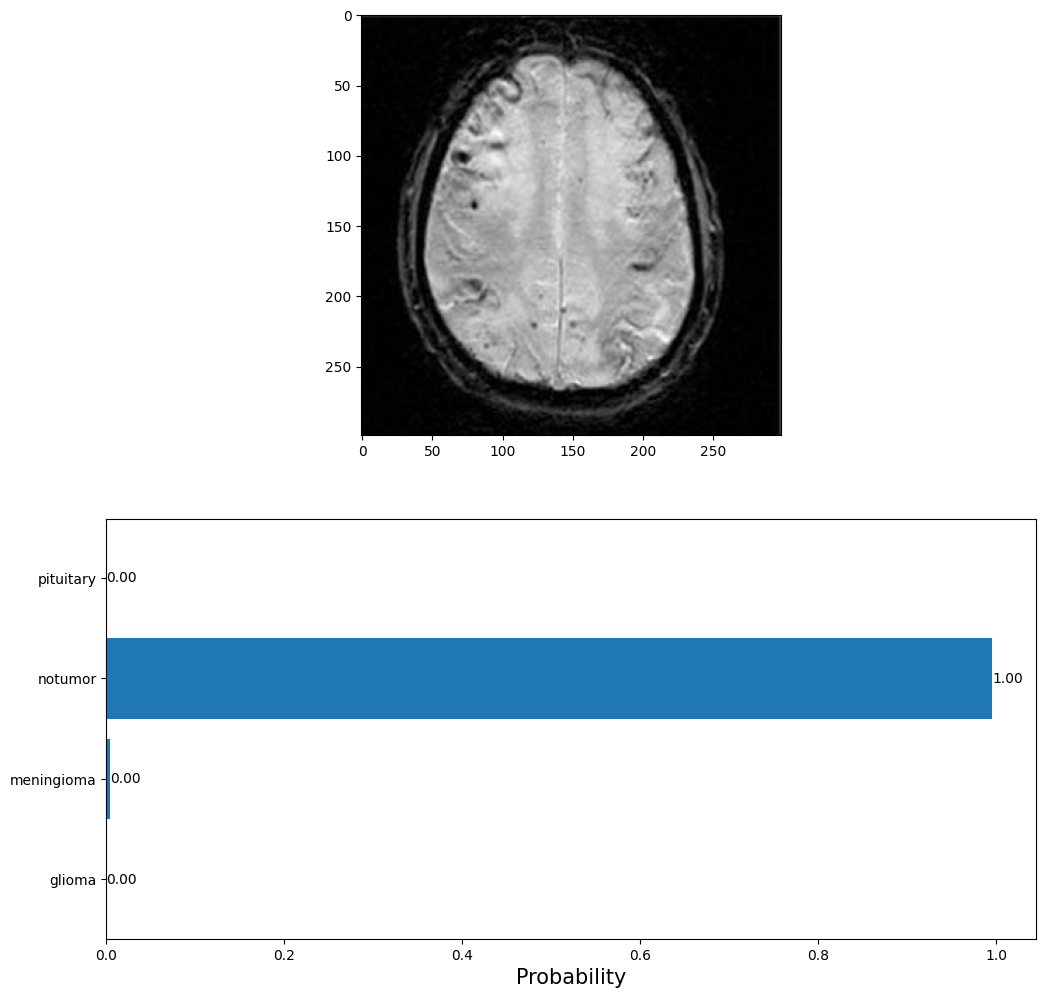

In [29]:
predict("/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0008.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3


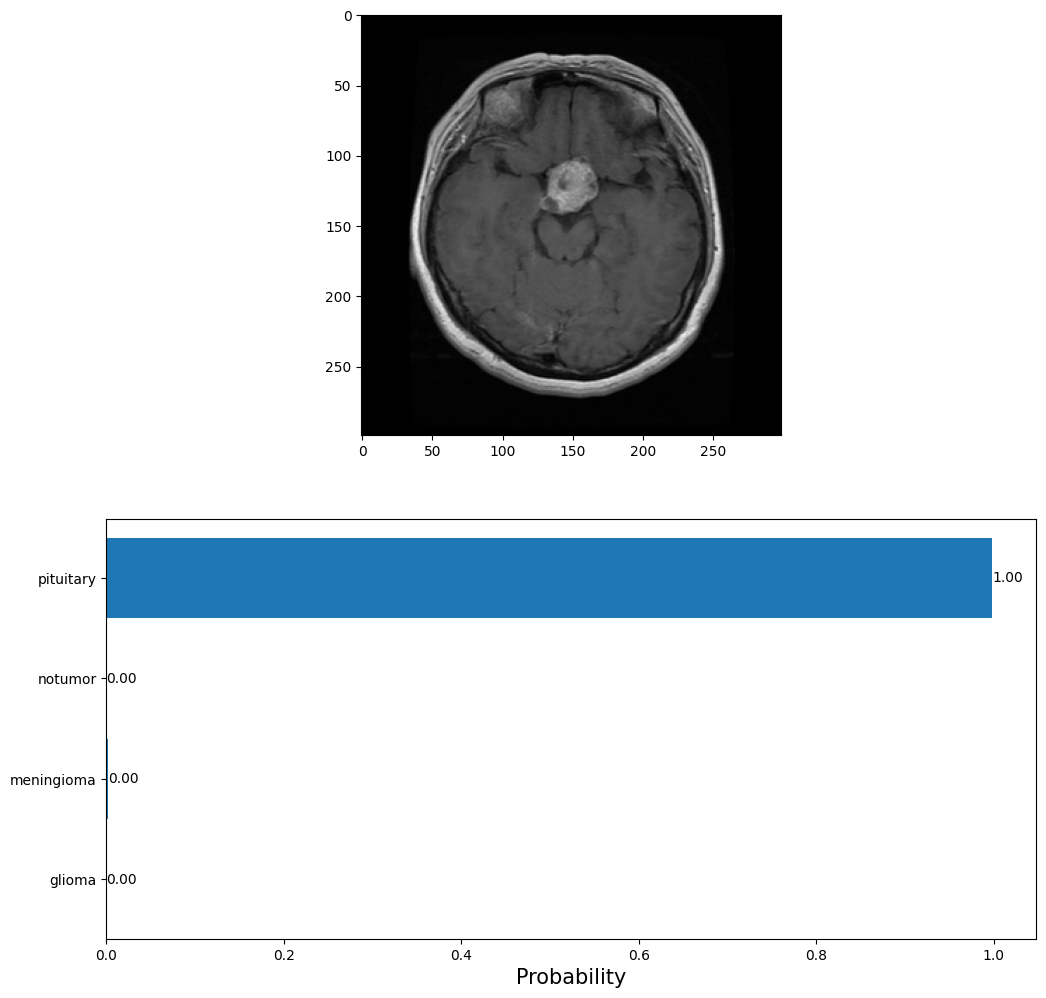

In [30]:
predict("/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0041.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1


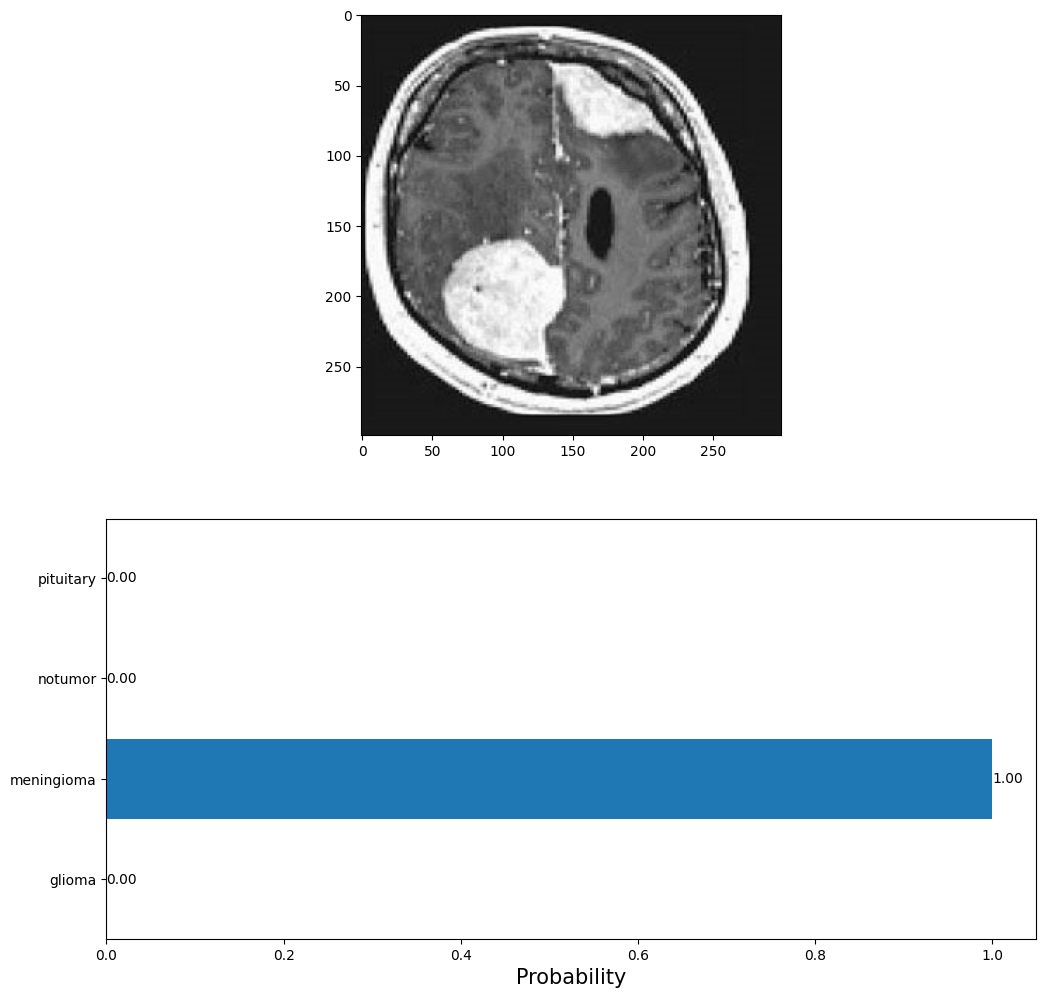

In [27]:
predict("/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0074.jpg")

In [31]:
#model.save("CNN_Model_1.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2


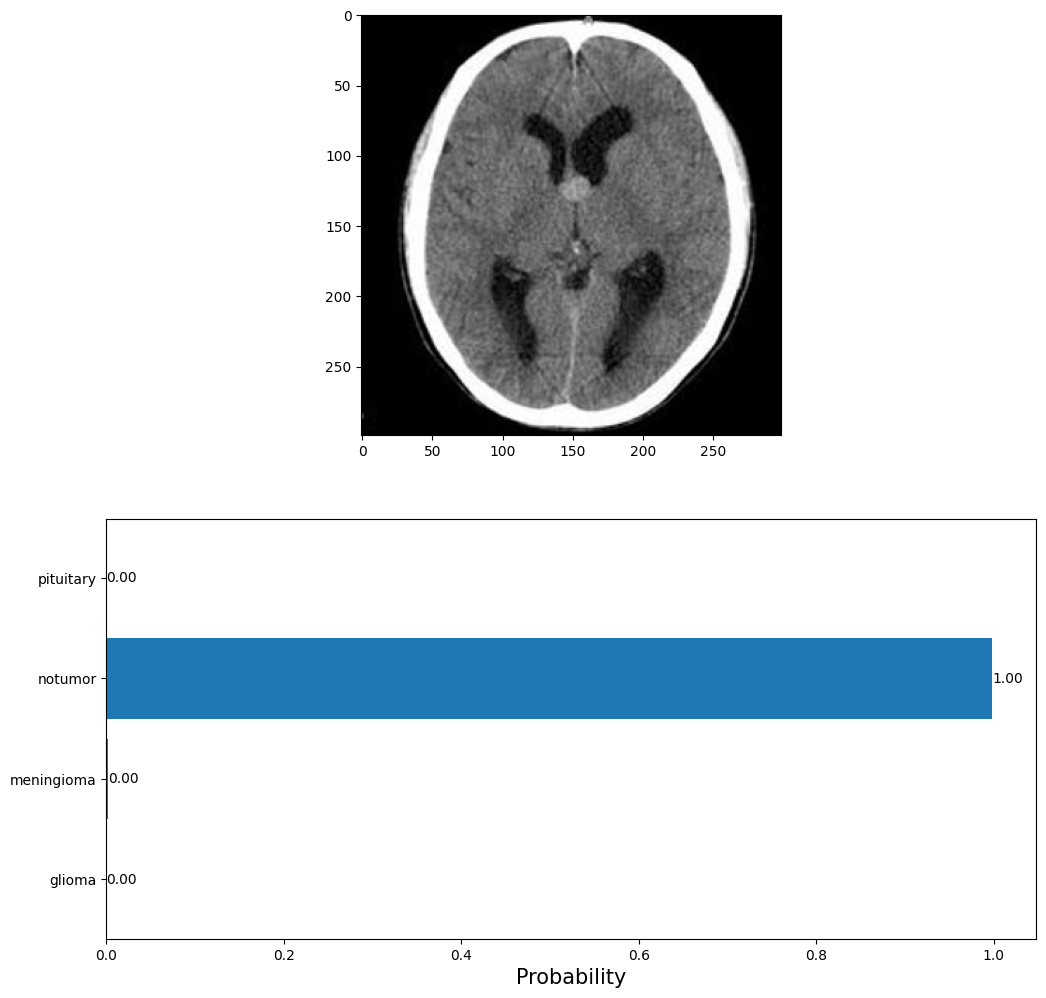

In [32]:
predict("/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0059.jpg")